In [1]:
import json
import os
import sys

import numpy as np
from river.decomposition import OnlineDMD
from river.preprocessing import Hankelizer
from river.utils import Rolling
from tqdm import tqdm

sys.path.append("../")

from functions.chdsubid import SubIDChangeDetector, get_default_rank
from functions.datasets import load_bess
from functions.plot import plot_chd
from functions.preprocessing import hankel

Rolling.learn_one = Rolling.update  # type: ignore

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Read data
X, y = load_bess()

In [4]:
window_size: int | None = 2 * 60 * 24
init_size = (
    window_size - 1
)  # Unsupervised usage reserves one iteration for contstructing y
# Base size
ref_size = 2 * 60 * 2
test_size = 2 * 60 * 2
# If window_size is not very large, then take half
h_max = int(2 * 60 / X.shape[1])
h_reco = 2 * 60 * 2
if h_reco < h_max:
    hn = h_reco
    hu = h_reco
    step = 1
else:
    hn = h_max
    hu = 1
    step = (h_reco) // h_max
# Optimal low-rank representation of signal with unknown noise variance
p = get_default_rank(hankel(X[:window_size], hn, step=step))
print(f"Optimal rank for states is: {p}")
# Snapshots weighting
w = 1.0

Optimal rank for states is: 48


In [5]:
p = 10

In [6]:
# [donotremove]
# Initialize Hankelizer
hankelizer = Hankelizer(hn)
# Initialize Transformer
odmd = OnlineDMD(
    r=p,
    initialize=init_size,
    w=w,
    exponential_weighting=False,
    eig_rtol=1e-1,
)
if window_size:
    odmd = Rolling(odmd, window_size)

# Initialize Change-Point Detector
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
    start_soon="soon",
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
# scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=complex)
dist = np.zeros((X.shape[0], 2), dtype=complex)
modes = np.empty((X.shape[0], hn * X.shape[1], p), dtype=complex)

# Run pipeline
for i, x in tqdm(
    enumerate(X.to_dict(orient="records")),
    total=len(X),
    mininterval=1.0,
    desc="Snapshots processed",
):
    scores_dmd[i] = pipeline_dmd.score_one(x)
    dist[i, :] = subid_dmd.distances
    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

    pipeline_dmd.learn_one(x)

    if subid_dmd.n_seen > window_size + test_size:
        modes[i, :, :] = odmd.modes

Snapshots processed: 100%|██████████| 20882/20882 [04:46<00:00, 73.00it/s] 


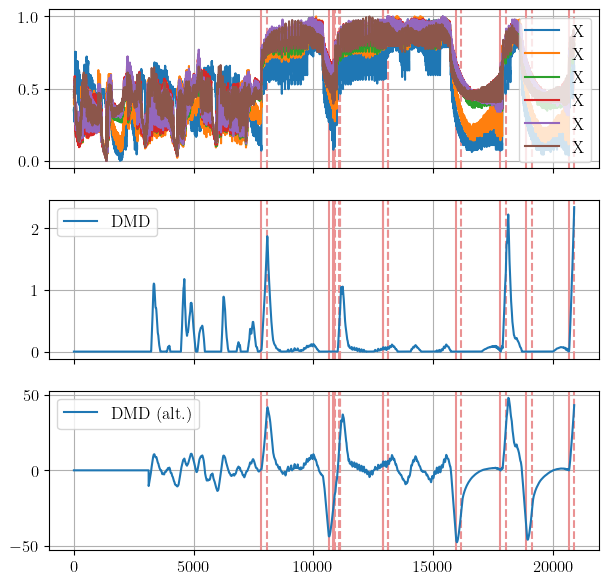

In [8]:
results_name = (
    f"results/.bess/bess-chd_p{p}-l{window_size}_b{ref_size}_t{test_size}"
    f"{'noroll' if window_size is None else f'roll_{window_size}'}-"
    f"dmd_w{w}-hx{hn}"
)

if "scores_dmd" not in locals():
    if os.path.exists(results_name + ".json"):
        results = json.load(open(results_name + ".json"))
        scores_dmd = np.array(results["scores_dmd"])
        scores_dmd_diff = np.array(results["scores_dmd_diff"])
    else:
        raise ValueError("No results found. Please rerun the experiment.")
else:
    results = {
        "params": {
            "p": str(p),
            "window_size": str(window_size),
            "init_size": str(init_size),
            "ref_size": str(ref_size),
            "test_size": str(test_size),
            "hn": str(hn),
        },
        "scores_dmd": scores_dmd.real.tolist(),
        "scores_dmd_diff": scores_dmd_diff.real.tolist(),
    }
    os.makedirs(os.path.dirname(results_name), exist_ok=True)

    json.dump(results, open(results_name + ".json", "w"))

# Plot results
fig, axs = plot_chd(
    [X.values, scores_dmd.real, scores_dmd_diff.real],
    np.where((y > 0.0).astype(int).diff().abs().fillna(0) > 0)[0],
    labels=["X", "DMD", "DMD (diff)", "SVD"],
    grace_period=test_size,
    ids_in_start=[],
    ids_in_end=[],
)

fig.savefig(results_name + ".pdf")